In [293]:
%reset -f
%config InteractiveShell.ast_node_interactivity = 'all'

# Fetching all Air Quality datasets into their dataframes
# Perform immediate concatenation per year
import os
import pandas as pd

# Initialize datasets using co (do not add extra datasets to dir)
dir = 'CAdata/'
colidx = [0,2,4,17]                             # column indexes to use
innerkeys = ['Date', 'Site ID', 'COUNTY']       # Merge on Date, Site ID, and County
dataA2020 = pd.read_csv(dir + 'cf-2020-co.csv', parse_dates=True, usecols=colidx)
dataA2021 = pd.read_csv(dir + 'cf-2021-co.csv', parse_dates=True, usecols=colidx)
dataA2022 = pd.read_csv(dir + 'cf-2022-co.csv', parse_dates=True, usecols=colidx)

with os.scandir(dir) as datasets:
    for dataset in datasets:
        if dataset.is_file() and 'co' not in dataset.name:
            temp = pd.read_csv(dataset, parse_dates=True, usecols=colidx)
            if '2020' in dataset.name:
                dataA2020 = pd.merge(dataA2020, temp, how='outer', on=innerkeys)
            elif '2021' in dataset.name:
                dataA2021 = pd.merge(dataA2021, temp, how='outer', on=innerkeys)
            elif '2022' in dataset.name:
                dataA2022 = pd.merge(dataA2022, temp, how='outer', on=innerkeys)

# Parse Dates to date
dataA2020['Date'] = pd.to_datetime(dataA2020['Date'])
dataA2021['Date'] = pd.to_datetime(dataA2021['Date'])
dataA2022['Date'] = pd.to_datetime(dataA2022['Date'])

# Group data by Date and Site ID, then by Date again to remove the Site ID feature
# Result would be mean measurements per day
# QUESTION: If regression is poor, let's do another one wherein we don't group by date
dataA2020 = dataA2020.groupby(by=['Date', 'Site ID']).mean().groupby(by=['Date']).mean()
dataA2021 = dataA2021.groupby(by=['Date', 'Site ID']).mean().groupby(by=['Date']).mean()
dataA2022 = dataA2022.groupby(by=['Date', 'Site ID']).mean().groupby(by=['Date']).mean()

dataA = pd.concat([dataA2020, dataA2021, dataA2022])    # Combine the three datasets

print("Combined dataset (Date set as index)")
dataA.head()

new_names = ['CO conc (ppm)', 'NO2 conc (ppb)', 'O3 conc (ppm)',
             'Pb conc (ug/m3 SC)', 'PM10 conc (ug/m3 SC)',
             'PM2.5 conc (ug/m3 LC)', 'SO2 conc (ppb)']

# Rename columns
for i in range(len(new_names)):
    dataA.rename(columns={dataA.columns[i]: new_names[i]}, inplace=True)

print("Columns renamed:")
dataA.head()

import seaborn as sns

# Deciding whether to drop or impute null values, so we check how many null values there are.
# Dataset A impute
print("A: Number of entries with null values:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

# These imports are important, imputer relies on them.

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer   # Important!
from sklearn.impute import IterativeImputer     # default imputer is BayesianRidge

from sklearn.linear_model import BayesianRidge

# Other estimators (estimator = func()) to try
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialize imputer
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True)
dataA[:] = imp.fit_transform(dataA)

print("After imputation:")
dataA.head()
print("A: Number of entries with null values after impute:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

Combined dataset (Date set as index)


,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2020-01-01,0.606780,19.129570,0.030783,0.008000,17.211765,13.533446,1.236
2020-01-02,0.643220,24.476087,0.028740,0.013000,16.750000,11.087611,1.228
2020-01-03,0.794915,28.616304,0.027643,0.018990,19.861446,13.664307,1.236
2020-01-04,0.817797,24.173913,0.031677,0.011233,19.096774,11.571699,1.140
2020-01-05,0.714407,20.461828,0.033058,0.009000,13.103659,9.578448,0.884


Columns renamed:


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-01,0.606780,19.129570,0.030783,0.008000,17.211765,13.533446,1.236
2020-01-02,0.643220,24.476087,0.028740,0.013000,16.750000,11.087611,1.228
2020-01-03,0.794915,28.616304,0.027643,0.018990,19.861446,13.664307,1.236
2020-01-04,0.817797,24.173913,0.031677,0.011233,19.096774,11.571699,1.140
2020-01-05,0.714407,20.461828,0.033058,0.009000,13.103659,9.578448,0.884


A: Number of entries with null values: 359
A: Number of entries: 1096
[IterativeImputer] Completing matrix with shape (1096, 7)
[IterativeImputer] Change: 0.013314017907579904, scaled tolerance: 0.2222875 
[IterativeImputer] Early stopping criterion reached.
After imputation:


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-01,0.606780,19.129570,0.030783,0.008000,17.211765,13.533446,1.236
2020-01-02,0.643220,24.476087,0.028740,0.013000,16.750000,11.087611,1.228
2020-01-03,0.794915,28.616304,0.027643,0.018990,19.861446,13.664307,1.236
2020-01-04,0.817797,24.173913,0.031677,0.011233,19.096774,11.571699,1.140
2020-01-05,0.714407,20.461828,0.033058,0.009000,13.103659,9.578448,0.884


A: Number of entries with null values after impute: 0
A: Number of entries: 1096


In [294]:
colidx = [0,1,2,5,6]     # column indexes to use (based on looking at dataB)
dataB = pd.read_csv('datasets/us_covid_cases_and_deaths_by_state.csv', parse_dates=True, usecols=colidx)
sum_new_cases = dataB['new_case'] + dataB['pnew_case']
dataB.drop(['new_case', 'pnew_case'], axis=1, inplace=True)
dataB['sum_new_cases'] = sum_new_cases
dataB.head()

dataB.columns = ['Date', 'State', 'Total Cases', 'Sum New Cases']

# Filter dataset B
dataB = dataB[dataB['State'] == 'CA']
dataB.head()

# Use Date as index, also drop the State
print("Dateset B finalized")
dataB['Date'] = pd.to_datetime(dataB['Date'])
dataB.set_index('Date', inplace=True)
dataB.sort_index(inplace=True)
dataB.drop('State', axis=1, inplace=True)
dataB.info()
dataB.head()

# Filter dataA with temporal restriction given by dataB
dataA = dataA[(dataA.index >= dataB.index.min()) &
              (dataA.index <= dataB.index.max())]

print("Filtered Dataset A")
dataA.head()

# With the printouts below, we find that there's no need to impute.
print("B: Number of entries with null values:", dataB.isna().any(axis=1).sum())
print("B: Number of entries:", dataB.shape[0])

,submission_date,state,tot_cases,sum_new_cases
0,03/11/2021,KS,297229,0.0
1,12/01/2021,ND,163565,809.0
2,01/02/2022,AS,11,0.0
3,11/22/2021,AL,841461,1060.0
4,05/30/2022,AK,251425,0.0


,Date,State,Total Cases,Sum New Cases
15543,06/11/2020,CA,139281,3090.0
15553,08/18/2020,CA,632667,4636.0
15562,02/25/2021,CA,3460326,4965.0
15573,02/10/2021,CA,3362981,8390.0
15576,09/06/2020,CA,732144,4905.0


Dateset B finalized
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1001 entries, 2020-01-22 to 2022-10-18
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total Cases    1001 non-null   int64  
 1   Sum New Cases  1001 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 23.5 KB


,Total Cases,Sum New Cases
Date,,
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0


Filtered Dataset A


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-22,0.525000,24.782447,0.031561,0.008904,13.844353,7.054452,0.743478
2020-01-23,0.670690,26.067553,0.025876,0.010460,15.817647,8.524138,1.087500
2020-01-24,0.690351,25.952660,0.026554,0.015000,17.476190,9.846121,1.052174
2020-01-25,0.585965,21.463402,0.028829,0.009500,18.971591,12.164924,1.433333
2020-01-26,0.508772,17.300521,0.033949,0.007000,16.000000,10.825797,0.954167


B: Number of entries with null values: 0
B: Number of entries: 1001


In [295]:
# Merging the two datasets (dataA & dataB)
data = dataA.merge(dataB, left_index=True, right_index=True)
data.head()

,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb),Total Cases,Sum New Cases
Date,,,,,,,,,
2020-01-22,0.525000,24.782447,0.031561,0.008904,13.844353,7.054452,0.743478,0,0.0
2020-01-23,0.670690,26.067553,0.025876,0.010460,15.817647,8.524138,1.087500,0,0.0
2020-01-24,0.690351,25.952660,0.026554,0.015000,17.476190,9.846121,1.052174,0,0.0
2020-01-25,0.585965,21.463402,0.028829,0.009500,18.971591,12.164924,1.433333,0,0.0
2020-01-26,0.508772,17.300521,0.033949,0.007000,16.000000,10.825797,0.954167,0,0.0


Number of entries remaining after pruning: 474


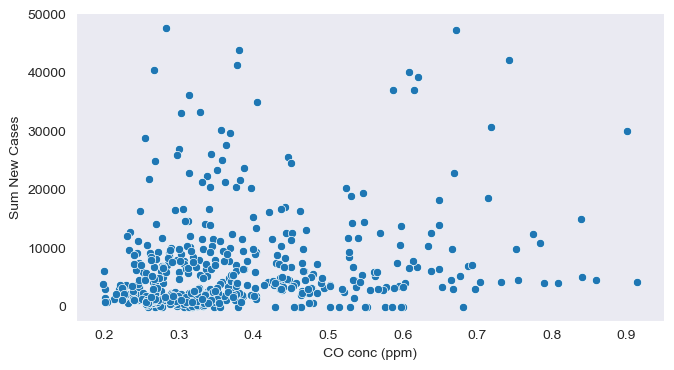

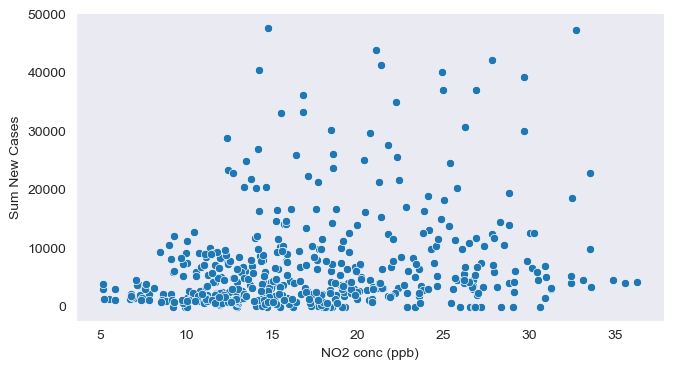

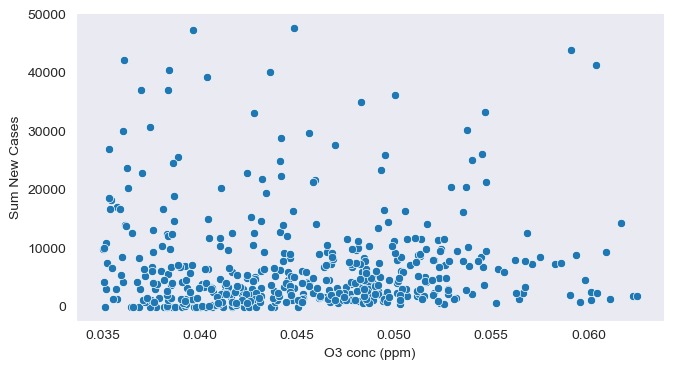

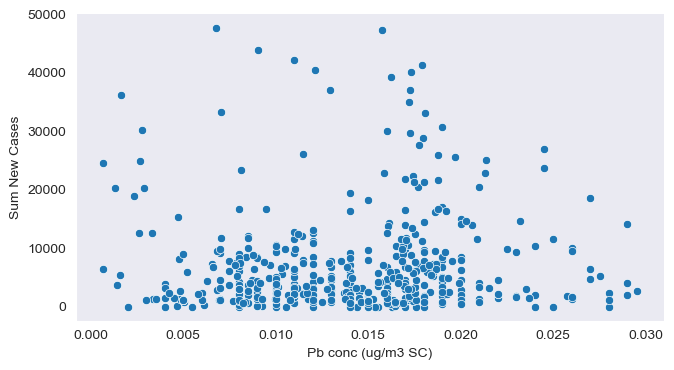

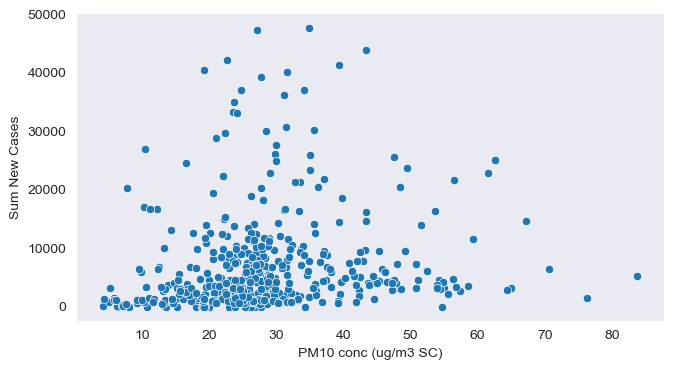

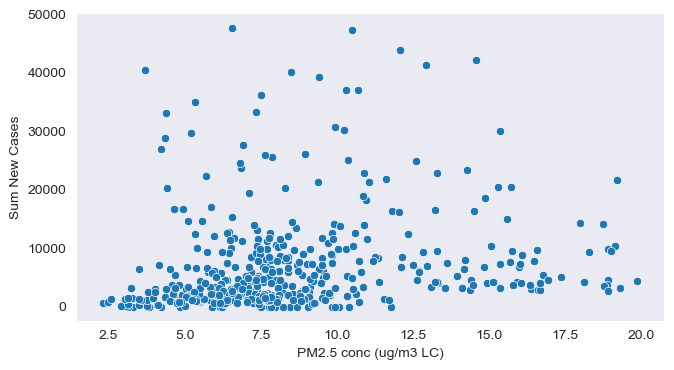

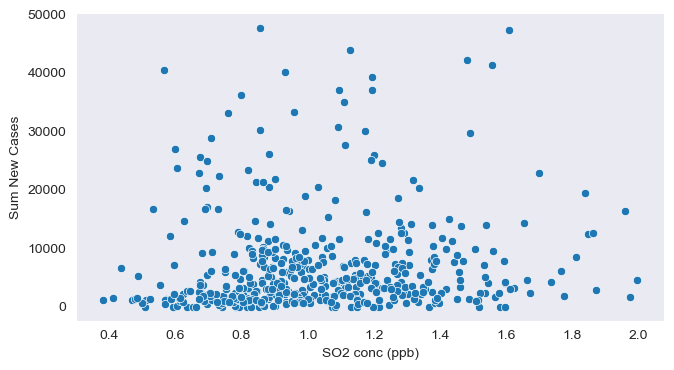

In [296]:
import matplotlib.pyplot as plt
%matplotlib inline

# GENERATE SCATTERPLOTS FOR EDUCATED GUESSES OF WHAT COLUMNS TO USE
# DYNAMIC PRUNING
# IDEA: We focus on ambient level of pollutants and ignore sudden spikes in COVID-19 case data (i.e. data dumps).
# We also remove Dates where there are no new infections as their volume skews the data alot.
data = data[(data['Sum New Cases'] <= 50000) & (data['Sum New Cases'] > 0)]
data = data[data['CO conc (ppm)'] <= 1.0]
# # data = data[data['NO2 conc (ppb)'] ]
data = data[data['O3 conc (ppm)'] > 0.035]
data = data[data['Pb conc (ug/m3 SC)'] < 0.03]
data = data[data['PM10 conc (ug/m3 SC)'] < 100]
data = data[data['PM2.5 conc (ug/m3 LC)'] < 20]
data = data[data['SO2 conc (ppb)'] < 2.0]

for label in data.columns:
    if label in ['Sum New Cases', 'Total Cases']: continue
    sns.set_style('dark')
    sns.relplot(x=label, y='Sum New Cases', data=data, height=3.8, aspect=1.8, kind='scatter')

print("Number of entries remaining after pruning:", data.shape[0])

# DROP COLUMNS HERE
data.drop(columns=['CO conc (ppm)', 'NO2 conc (ppb)', 'O3 conc (ppm)'], axis=1, inplace=True)

<AxesSubplot:xlabel='Pb conc (ug/m3 SC)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='PM10 conc (ug/m3 SC)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='PM2.5 conc (ug/m3 LC)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='SO2 conc (ppb)', ylabel='Sum New Cases'>

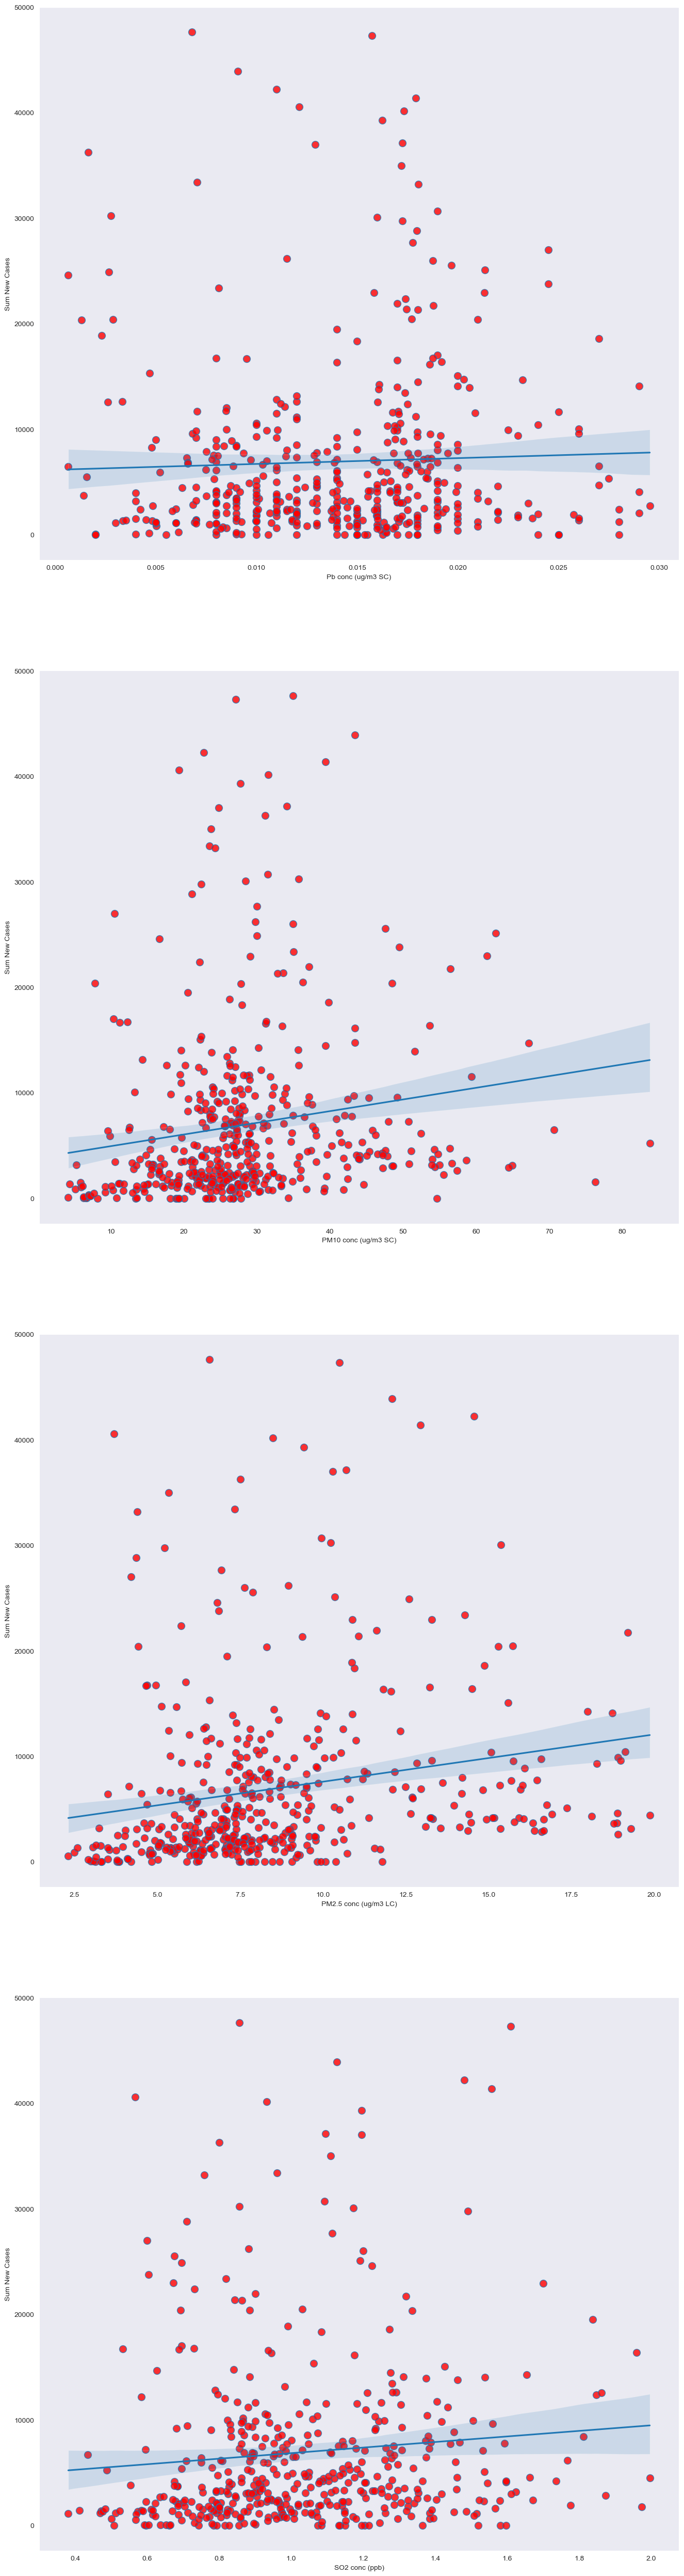

In [297]:
fig, axs = plt.subplots(nrows=len(data.columns)-2, ncols=1, figsize=(16,64))

i = 0
for label in data.columns:
    if label in ["Sum New Cases", "Total Cases"]: continue
    sns.regplot(x=label, y='Sum New Cases', data=data, ci=95, scatter_kws={'s':100, 'facecolor':'red'}, ax=axs[i])
    i += 1

In [298]:
# Linear Regression
# PREPARE FEATURES AND TARGET DATA
X = data.iloc[:,0:-1] # feature matrix
X
y = data.iloc[:,-1] # target vector

# PREPARE TRAIN AND TEST DATA
# NOTE: random_state = 1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# TODO: Hyperparameter tuning
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

,Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb),Total Cases
Date,,,,,
2020-02-02,0.025000,54.617284,7.957522,1.134783,3
2020-02-03,0.016277,26.727401,3.837572,0.508333,6
2020-02-12,0.015000,23.241379,8.467881,1.204167,7
2020-02-13,0.015000,23.439759,10.083475,0.784000,8
2020-02-18,0.015500,26.770588,9.829978,1.215385,13
...,...,...,...,...,...
2022-09-30,0.017910,28.989474,6.876210,1.434783,11253453
2022-10-06,0.021344,62.644330,10.356299,1.191304,11278564
2022-10-07,0.020856,59.335052,9.867829,1.182609,11284337


LinearRegression()

Coefficients: [-5.54783935e+04 -5.11484754e+01  5.86705258e+02 -1.81038664e+03
  1.31970398e-03]
Intercept: 1874.4987381917626


In [299]:
y_pred = regressor.predict(X_test)
y_pred

array([ 4242.64158713,  8437.8571243 ,  1337.44920629, 15536.03865343,
        6490.44248985,  6828.89360259,  7844.11008986,  6798.63552609,
        2900.81567225,  4161.26549363,  6660.30017481,  3319.39631829,
        8068.66194893,  7358.82924944,  8022.19660016,  2150.63725863,
        5498.22956117,  9151.91315053,  9194.012642  , 13742.02980509,
        6155.53031826,  5600.16893465,  6180.47588949,  3212.30951321,
        6458.73097264,  9547.84134378,  7309.81426141,  6678.84719673,
       14435.9563614 ,  2266.82245615,  6109.04471607,  5638.73642981,
        4020.86334747, 10597.17896913,  2445.55028549,  8763.11112193,
        7017.51630391,  2825.98396665, 10883.13461212,  3991.48716894,
        6659.68580252,  2124.00746203, 11766.76329423,  6260.663626  ,
        1496.92064536,  8433.56464733, 21099.58182955,  5812.49070127,
        2742.6800892 ,  4133.58078853, 13552.88055817, 13299.89606456,
        7379.89487344, 16326.28681899,  6873.16154142,  9511.83255566,
      

In [300]:
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparison_df

,Actual,Predicted
Date,,
2020-10-11,3803.0,4242.641587
2021-05-30,1079.0,8437.857124
2020-03-23,265.0,1337.449206
2022-04-29,26195.0,15536.038653
2021-03-11,3184.0,6490.442490
...,...,...
2020-04-23,1973.0,1784.653532
2021-04-25,1739.0,5878.043870
2020-04-01,1223.0,2134.361651


In [301]:
residuals = y_test - y_pred
residuals

Date
2020-10-11     -439.641587
2021-05-30    -7358.857124
2020-03-23    -1072.449206
2022-04-29    10658.961347
2021-03-11    -3306.442490
                  ...     
2020-04-23      188.346468
2021-04-25    -4139.043870
2020-04-01     -911.361651
2021-07-15    -4459.969578
2021-03-07    -3285.239011
Name: Sum New Cases, Length: 143, dtype: float64

<AxesSubplot:xlabel='Sum New Cases'>

Text(0.5, 0, 'y_test data')

Text(0, 0.5, 'Predictions')

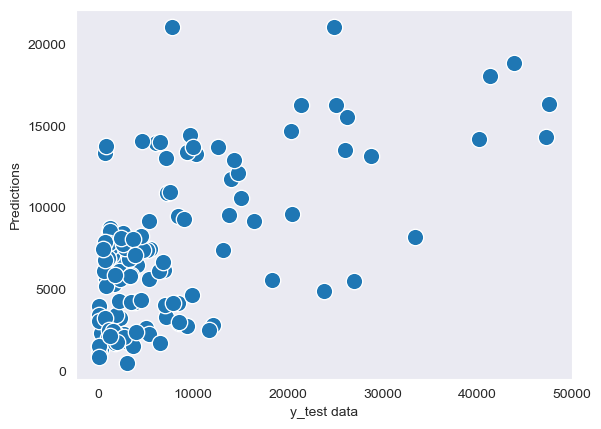

In [302]:
sns.scatterplot(x=y_test, y = y_pred, s=140)
plt.xlabel('y_test data')
plt.ylabel('Predictions')

In [303]:
from sklearn.metrics import mean_absolute_error
print('MAE:', mean_absolute_error(y_test,y_pred))

from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))

import numpy as np
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2 Score:", r2)      # We use this as our main metric

MAE: 5336.218550006875
MSE 63027490.948043354
RMSE 7938.985511262969
R2 Score: 0.3437923776807058


In [304]:
data = data.reset_index()
NewData = data
NewData

,Date,Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb),Total Cases,Sum New Cases
0,2020-02-02,0.025000,54.617284,7.957522,1.134783,3,3.0
1,2020-02-03,0.016277,26.727401,3.837572,0.508333,6,3.0
2,2020-02-12,0.015000,23.241379,8.467881,1.204167,7,1.0
3,2020-02-13,0.015000,23.439759,10.083475,0.784000,8,1.0
4,2020-02-18,0.015500,26.770588,9.829978,1.215385,13,5.0
...,...,...,...,...,...,...,...
469,2022-09-30,0.017910,28.989474,6.876210,1.434783,11253453,11226.0
470,2022-10-06,0.021344,62.644330,10.356299,1.191304,11278564,25111.0
471,2022-10-07,0.020856,59.335052,9.867829,1.182609,11284337,11546.0
472,2022-10-13,0.018014,32.786458,9.380859,0.863636,11305666,21329.0


In [305]:
# For CO conc (ppm) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['CO conc (ppm)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['Date'].dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='Date'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 & Air Quality Index',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

KeyError: 'CO conc (ppm)'

In [ ]:
# For NO2 conc (ppb) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['NO2 conc (ppb)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['NO2 conc (ppb)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='NO2 conc (ppb)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 & Air Quality Index',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
# For O3 conc (ppm) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['O3 conc (ppm)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['Date'].dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='Date'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 & Air Quality Index',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()